# Shedding Light on the Dark: Analyzing the Proportion of Daytime vs Nighttime Thefts in Vancouver

Group 2: Rui Xiang Yu, Lily Zhang, Bill Makwae & Ruoxi Chen

### 1. Introduction
Vancouver's population was reported to be 662,248 in 2021, making it one of the biggest cities in Canada (Statistics Canada, 2023). As such, it is expected for crimes, such as theft, to happen. 

With this project, we aim to answer the following inferential question: does the proportion of theft-related crimes committed during the day differ from those committed at night? The conclusions from this project could be extrapolated to the entirety of Vancouver and other Canadian cities of similar population density.

It was found that predicted robbery rates in the United Kingdom increased the darker the areas were (Tompson & Bowers, 2013). Furthermore, commercial robberies in the Netherlands happened more during winter due to more dark hours during the season (Van Koppen & Jansen, 1999). Based on the current literature, our hypothesis is that the proportion of theft is higher at night.

The dataset used for this project is the Vancouver Police Department's Crime Data, which contains the data about most crimes committed in Vancouver such as when they happened, where they happened, and what type of crime it was(Vancouver Police Department, 2023). The dataset contains the information of 853296 crimes, but when filtered for theft only crimes, it becomes 529238 crimes.

The variables "hour" and "number of crimes" will be used. Since the main focus is the count of crimes committed on the day VS night, the proportion of crimes in the day VS night will be studied. Furthermore, the standard deviation will be studied too in order to report a confidence interval and study the spread of the distribution.

For the purpose of this project, daytime is defined as the time between 6 am (inclusive) and 18 pm, and nighttime between 18 pm (inclusive) and 6 am. The overall proportion of day VS night crimes will be studied, which means it is not a comparison per year or per day.

### 2. Methods and Results

#### 2.1. Preliminary Results

Firstly, the dataset is loaded and tidied to include only the necessary columns.

In [1]:
#Loading all necessary libraries.
library(dplyr)
library(ggplot2)
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(RColorBrewer)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ purrr   0.3.4
✔ tidyr   1.2.1     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
#Reading the dataset from the web into Jupyter and previewing the first 6 rows.
vancouver_crime_data <- read.csv(url("https://raw.githubusercontent.com/xnrxng/stat201project/main/crimedata_csv_AllNeighbourhoods_AllYears.csv"))
head(vancouver_crime_data)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,Other Theft,2019,3,14,10,34,47XX OAK ST,South Cambie,490706.9,5454474
2,Other Theft,2005,8,1,0,0,47XX OAK ST,South Cambie,490706.9,5454474
3,Other Theft,2012,12,6,9,30,47XX OAK ST,South Cambie,490706.9,5454474
4,Other Theft,2004,1,25,17,0,47XX OAK ST,South Cambie,490710.6,5454535
5,Other Theft,2020,9,22,11,36,47XX OSLER ST,Shaughnessy,490528.5,5454450
6,Other Theft,2003,8,18,7,30,47XX OSLER ST,Shaughnessy,490529.8,5454502


*Table 1.1. First six rows of the loaded Crime Dataset.*

In [3]:
#Printing total number of crimes that have happened in Vancouver.
cat("Number of Crimes: ", nrow(vancouver_crime_data))

Number of Crimes:  853296

In [4]:
#Selecting only theft-related crimes and mutating hours into "day" and "night". Crimes that happened
#between 6 am and 18 pm are considered "day" and the rest are considered "night". NA values are also
# filtered out. Lastly, only columns of interest are selected (type, day_night). Hour is also
# selected for graphing purposes.
vancouver_thefts <- vancouver_crime_data %>%
    filter(TYPE == "Other Theft" | TYPE == "Theft from Vehicle" | TYPE == "Theft of Vehicle" | TYPE == "Theft of Bicycle",
          !is.na(TYPE),
          !is.na(HOUR)) %>%
    mutate(DAY_NIGHT = ifelse(HOUR >= 6 & HOUR < 18, "DAY", "NIGHT")) %>%
    select(TYPE, HOUR, DAY_NIGHT)

#Previewing first six rows.
head(vancouver_thefts)

,TYPE,HOUR,DAY_NIGHT
,<chr>,<int>,<chr>
1,Other Theft,10,DAY
2,Other Theft,0,NIGHT
3,Other Theft,9,DAY
4,Other Theft,17,DAY
5,Other Theft,11,DAY
6,Other Theft,7,DAY


*Table 1.2. First six rows of the dataset with selected interested columns.*

In [5]:
#Obtaining the total number of crimes per type of theft-related crime.
theft_counts <- vancouver_thefts %>%
    group_by(TYPE) %>%
    summarise(COUNT = n())
theft_counts

TYPE,COUNT
<chr>,<int>
Other Theft,210540
Theft from Vehicle,237891
Theft of Bicycle,36403
Theft of Vehicle,44404


*Table 1.3. Number of crimes per type of theft-related crime.*

In [6]:
#Obtaining the total number of crimes per type of theft-related crime and whether it is day or night.
# Also obtaining its proportion.
theft_counts_by_type <- vancouver_thefts %>%
  group_by(TYPE, DAY_NIGHT) %>%
  summarise(COUNT = n()) %>%
  mutate(PROP = COUNT / sum(COUNT))
theft_counts_by_type

`summarise()` has grouped output by 'TYPE'. You can override using the
`.groups` argument.


TYPE,DAY_NIGHT,COUNT,PROP
<chr>,<chr>,<int>,<dbl>
Other Theft,DAY,132566,0.6296476
Other Theft,NIGHT,77974,0.3703524
Theft from Vehicle,DAY,102276,0.4299280
Theft from Vehicle,NIGHT,135615,0.5700720
Theft of Bicycle,DAY,19634,0.5393512
Theft of Bicycle,NIGHT,16769,0.4606488
Theft of Vehicle,DAY,17364,0.3910459
Theft of Vehicle,NIGHT,27040,0.6089541


*Table 1.4. Number and proportion of crimes that occured per theft-type and whether it was night or day.*

In [7]:
#Obtaining number of crimes that occur per hour of the day.
theft_counts_hour <- vancouver_thefts %>%
  group_by(HOUR) %>%
  summarise(COUNT = n())
head(theft_counts_hour)

HOUR,COUNT
<int>,<int>
0,30102
1,11896
2,8392
3,6120
4,5054
5,5046


*Table 1.5. Number of theft crimes that occur per hour of the day.*

In [8]:
#Obtaining overall number of crimes that happen during the day vs night and their proportions.
theft_counts_by_day_night <- vancouver_thefts %>%
  group_by(DAY_NIGHT) %>%
  summarise(COUNT = n()) %>%
  mutate(PROP = COUNT / sum(COUNT))
theft_counts_by_day_night

DAY_NIGHT,COUNT,PROP
<chr>,<int>,<dbl>
DAY,271840,0.5136441
NIGHT,257398,0.4863559


*Table 1.6. Table of estimates. Number and proportion of theft crimes in the day and in the night.*

In [17]:
# Obtaining observed difference in proportions.

obs_diff_prop <- theft_counts_by_day_night$PROP[1] - theft_counts_by_day_night$PROP[2]

obs_diff_prop

[1] 0.02728829

In [21]:
# Obtaining the tidied dataset with ONLY the interested columns (type, day-night).
# All kinds of theft are recoded as one major factor named "Theft".
# Other crimes are grouped together as "Other".
# This is the dataset that will be used during the analysis.
theft_tidy <- vancouver_crime_data %>%
select(TYPE, HOUR) %>%
mutate(TYPE = recode_factor(TYPE, `Other Theft` = "Theft",
                                  `Theft from Vehicle` = "Theft",
                                  `Theft of Vehicle` = "Theft",
                                  `Theft of Bicycle` = "Theft",
                                  `Vehicle Collision or Pedestrian Struck (with Fatality)` = "Other",
                                  `Vehicle Collision or Pedestrian Struck (with Injury)` = "Other",
                                  `Break and Enter Commercial` = "Other",
                                  `Break and Enter Residential/Other` = "Other",
                                  `Homicide` = "Other",
                                  `Mischief`= "Other",
                                  `Offence Against a Person`= "Other")) %>%
mutate(DAY_NIGHT = ifelse(HOUR >= 6 & HOUR < 18, "DAY", "NIGHT")) %>%
select(TYPE, DAY_NIGHT)


#Previewing first 6 columns.
head(theft_tidy)

,TYPE,DAY_NIGHT
,<fct>,<chr>
1,Theft,DAY
2,Theft,NIGHT
3,Theft,DAY
4,Theft,DAY
5,Theft,DAY
6,Theft,DAY


*Table 1.7. Final tidy dataset with only column of interest "day_night".*

In [22]:
# Obtaining total number of theft related crimes.
n = theft_tidy%>%
filter(TYPE == "Theft") %>%
nrow()
n

[1] 529238

In [23]:
# Graphing a bar plot of the proportion of crimes based on theft-type and whether it is day or night.
theft_counts_by_type_plot <- theft_counts_by_type |>
  ggplot(aes(x=TYPE, y=PROP, fill=DAY_NIGHT)) +
  geom_bar(stat="identity", position="dodge") +
  labs(x="Type of Crime", y="Proportion of Crimes", fill="Day/Night") +
  ggtitle("Proportion of Crimes \nby Type and Day/Night") +
  theme(text = element_text(size=14)) +
theme(axis.text.x = element_text(angle = 9, hjust = 1, vjust = 0.5)) +
scale_fill_brewer(palette = "Set2")

#Graphing a histogram plot of the number of crimes that happen per each hour of the day.
theft_counts_hour_plot <- ggplot(theft_counts_hour, aes(x=HOUR, y=COUNT)) +
  geom_bar(stat="identity") +
  labs(x="Hour of Day (Shaded area indicates daytime)", y="Number of Crimes") +
  ggtitle("Distribution of Crimes by Hour of Day") +
  theme(text = element_text(size=20)) +
geom_vline(xintercept=6, color= "blue", linetype = "dashed", size = 1) +
geom_vline(xintercept=18, color= "blue", linetype = "dashed", size = 1) +
geom_rect(aes(xmin = 6, xmax = 18, ymin = 0, ymax = Inf), fill = "gray", alpha = 0.03)

#Graphing a bar plot of the proportion of crimes that happen in the day vs night.
# These are our estimates.
theft_counts_by_day_night_plot <- 
  ggplot(theft_counts_by_day_night, aes(x=DAY_NIGHT, y=PROP, fill=DAY_NIGHT)) +
  geom_bar(stat="identity") +
  labs(x = "Daytime and Nighttime", y= "Proportion of Crimes", fill="Time of Day") +
  ggtitle("Proportion of Crimes by Time of Day") +
  theme(text = element_text(size=14)) +
scale_fill_brewer(palette = "Set2")

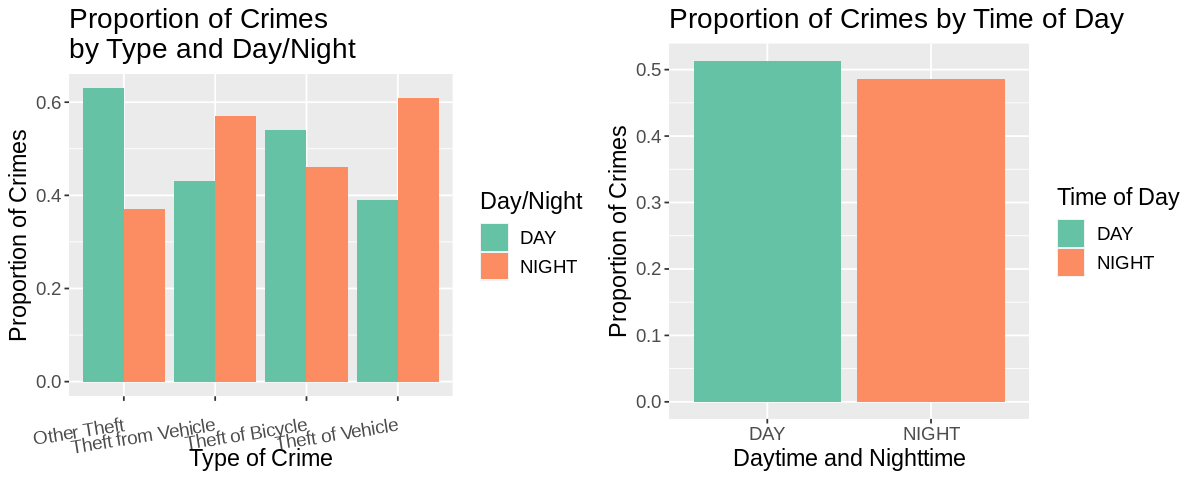

In [24]:
options(repr.plot.width = 10, repr.plot.height = 4) 
plot_grid(theft_counts_by_type_plot, theft_counts_by_day_night_plot, ncol = 2)

*Figure 1.1. Top left: bar chart of the proportion of crimes per theft type and whether it was daytime or nighttime.*

*Figure 1.2. Top right: bar chart of the proportion of theft-related crimes in the day vs in the night.*

# [INSERT DESCRIPTION OF THE GRAPHS. WHAT DO WE SEE? WHAT CAN WE TELL? INTERPRETATION.]

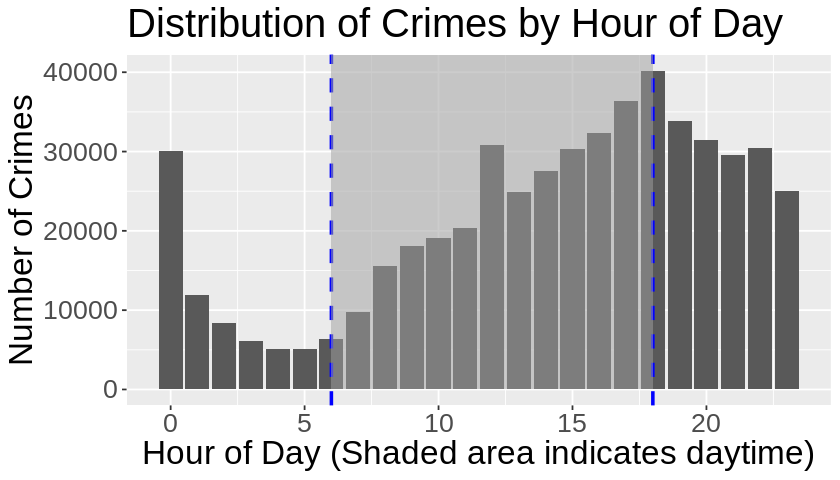

In [25]:
options(repr.plot.width = 7, repr.plot.height = 4)
theft_counts_hour_plot

*Figure 1.3. Histogram of number of crimes per hour of the day.*

# [INSERT DESCRIPTION OF THE GRAPH. WHAT DO WE SEE? WHAT CAN WE TELL? INTERPRETATION.]

The use of this data is supported by the reliability of the data source and standardized procedures for data collection completed by the Vancouver Police Department, ensuring accuracy and consistency in the classification of crimes and time of occurrence.

Due to privacy and investigative reasons, not all crime data is included in the dataset, so our current graphs do not have a complete picture of crime in Vancouver. And furthermore, we will use this data to infer the proportion of theft occurring during day and night in other Canadian cities of similar population density.

To perform our analysis, we will use $p_0$ and $p_1$ to represent the proportion of theft that occurred at night and day respectively. We will conduct a hypothesis test on the proportions at a significance level of 5%, with $H_0: p_0 = p_1$ (null hypothesis) and $H_a: p_0 > p_1$ (alternative hypothesis). In other words, our null hypothesis is that the proportion of theft occurring during the day is the same as the proportion occurring at night, while our alternative hypothesis is that the proportion occurring at night is higher than daytime. And we will conduct hypothesis testing using both bootstrapping and theory-based methods. Additionally, we will construct a 95% confidence interval using the standard deviation found through bootstrapping.

We are expecting to find less proportion of theft during the day than the night for this report. By obtaining the result, we can raise people's awareness of the time of occurrences of theft in Canada with the support of data. And for later investigation, we would like to suggest analyzing other categories of crime and the time of occurrence to see whether all crimes share similar nature in the time of occurrence.

#### 2.2. Bootstrapping method

We first code the null distribution:

In [26]:
set.seed(2023)

#Obtaining a null distribution where p0 = p1. Meaning the same amount of thefts happen in the day and in the night.

null_dist <- theft_tidy %>% 
specify(formula = TYPE ~ DAY_NIGHT, success = "Theft") %>% 
hypothesize(null = "independence") %>% 
generate(reps = 30, type = "permute") %>% 
calculate(stat = "diff in props", order = c("DAY", "NIGHT"))

# Previewing first six rows of the null distribution.
head(null_dist)

replicate,stat
<int>,<dbl>
1,-7.204417e-04
2,7.020271e-04
3,9.099628e-04
4,-4.983287e-04
5,1.684996e-03
6,2.623627e-05


*Table 2.1. Null distribution.*

In [27]:
# Obtaining the p-value.
p_val <- null_dist %>% 
get_p_value(obs_stat = obs_diff_prop, direction = "both")

p_val

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


*Table 2.2. Tibble with the obtained p-value.*

In [19]:
set.seed(2023)

#Obtaining a bootstrap distribution of the sample.

boot_dist <- theft_tidy %>%
specify(response = TYPE ~ DAY_NIGHT, success = "Theft") %>%
generate(reps = 30, type = "bootstrap") %>%
calculate(stat = "diff in props", order = c("DAY", "NIGHT"))

head(bool_dist)

ERROR: [1m[33mError[39m in [1m[1m`vectbl_as_col_location2()`:[22m
[33m![39m Must extract column with a single valid subscript.
[31m✖[39m Subscript `response_name(x)` has size 3 but must be size 1.


In [ ]:
# Obtaining a 95% confidence interval.
percentile_ci <- boot_dist %>% 
  get_confidence_interval(level = 0.95, type = "percentile")
percentile_ci

*Table 2.3. 95% confidence interval of the bootstrap distribution.*

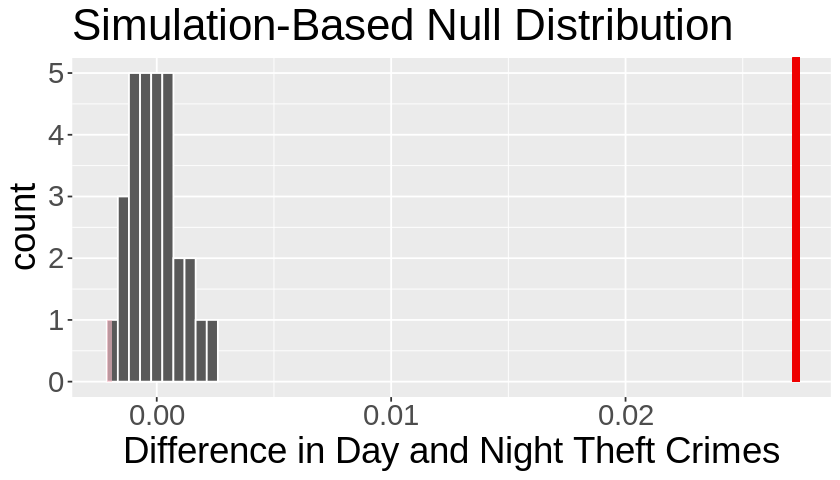

In [28]:
# Graphing the null distribution with its p-value.
null_plot <- 
visualize(null_dist, bins = 10) + 
shade_p_value(obs_stat = obs_diff_prop, direction = "both") +
theme(text = element_text(size = 22)) +
xlab("Difference in Day and Night Theft Crimes")

# Graphing the bootstrap distribution with its confidence interval.
boot_plot <- boot_dist %>% 
ggplot(aes(x = stat)) +
geom_histogram(binwidth = 10, fill = "#480087", colour = "white") +
geom_vline(xintercept = percentile_ci[[1]], colour = "#2fed2f", size = 2) +
geom_vline(xintercept = percentile_ci[[2]], colour = "#2fed2f", size = 2) +
 annotate("rect",
             xmin = percentile_ci[[1]], xmax = percentile_ci[[2]],
             ymin = -Inf, ymax = Inf,
             fill = "#2fed2f",
             alpha = 0.2) +
 scale_y_continuous(limits = c(0, 800)) +
scale_x_continuous(limits = c(280, 500), breaks = seq(200, 600, 20)) +
annotate("text",
             x = percentile_ci[[1]] + 2,
             y = 750,
             hjust = 0,
             label = paste(round(percentile_ci[[1]]))) +
annotate("text",
             x = percentile_ci[[2]] - 2,
             y = 750,
             hjust = 1,
             label = paste(round(flow_ci[[2]]))) +
labs(title = "Simulated Bootstrap Distribution (30 reps)\nWith 95% C.I",
         subtitle = "For difference in proportion of day and night theft crimes",
         x = "Difference in Day and Night Theft Crimes",
         y = "Frequency") +
theme_bw()

options(repr.plot.width = 10, repr.plot.height = 4) 
plot_grid(null_plot, boot_plot, ncol = 2)

*Figure 2.1. Left. Histogram of the null distribution with its p-value shaded.*

*Figure 2.2 Right. Histogram of the bootstrap distribution with its 95% CI shaded.*

#### 2.3. Theory-based method

#### 2.4. Compilation of data

Do you think one of bootstrapping or asymptotics is more appropriate than the other? Why or why not? Explain why you think both methods gave you similar/different results, and whether you think one is more trustworthy than the other.

### 3. Discussion
In this section, you’ll interpret the results you obtained in the previous section with respect to the main question/goal of your project.

- Summarize what you found, and the implications/impact of your findings.
- If relevant, discuss whether your results were what you expected to find.
- Discuss future questions/research this study could lead to.

### 4. References
Statistics Canada (2023). *Census Profile: 2021 Census of Population*. Statistics Canada Catalogue. https://www12.statcan.gc.ca/census-recensement/2021/dp-pd/prof/index.cfm?Lang=E.

Tompson, L., & Bowers, K. (2013). A Stab in the Dark?: A Research Note on Temporal Patterns of Street Robbery. *The Journal of research in crime and delinquency, 50*(4), 616–631. https://doi.org/10.1177/0022427812469114.

Vancouver Police Department (2023). *Crime Data* [Data set]. The Vancouver Police Department. https://geodash.vpd.ca/opendata/.

Van Koppen, P. J., & Jansen, R. W. J. (1999). The Time to Rob: Variations in Time of Number of Commercial Robberies. *Journal of Research in Crime and Delinquency, 36*(1), 7–29. https://doi.org/10.1177/0022427899036001003.